# Example 1 - Detection and quantification in Quantitative field imaging

xxx

## 1. Imports

In [1]:
import sys
sys.path.insert(0, "../") # Adds the module to path
import deeptrack as dt

In [2]:
import deeplay as dl

In [3]:
import numpy as np
import matplotlib.pyplot as plt

## 2. Detection in Quantitative field imaging

Let's start by loading in data in the quantitiative field regime.

In [4]:
data = np.load("../data/brightfield_data.npy") #Quantitative field
labels = np.load("../data/brightfield_labels.npy") #Labels for the particles

In [5]:
#Subtracting mean in the real part so that the data is centered
data[...,0] = data[...,0] - 1

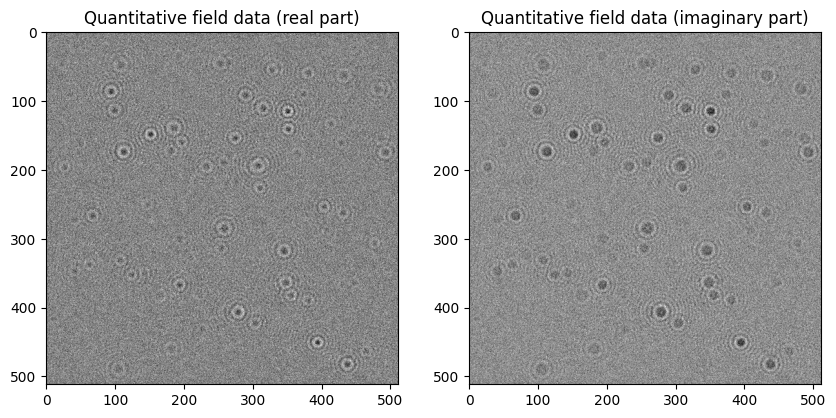

In [6]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.imshow(data[...,0], cmap="gray")
plt.title("Quantitative field data (real part)")
plt.subplot(122)
plt.imshow(data[...,1], cmap="gray")
plt.title("Quantitative field data (imaginary part)")
plt.show()

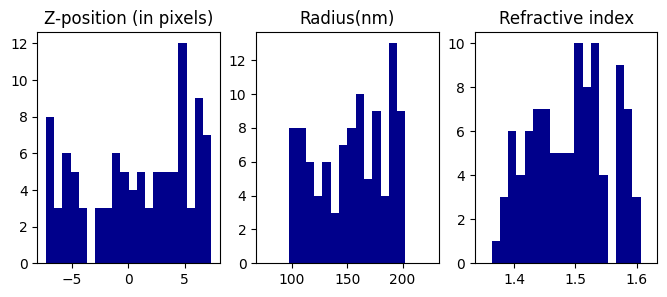

In [7]:
#Subplot of the distribution of the labels
plt.figure(figsize=(8,3))
plt.subplot(131)
plt.hist(labels[:,2], bins=20, color = 'darkblue')
plt.title("Z-position (in pixels)")
plt.subplot(132)
plt.hist(labels[:,3]*1e9, bins=20, color = 'darkblue', range=(75, 225))
plt.title("Radius(nm)")
plt.subplot(133)
plt.hist(labels[:,4], bins=20, color = 'darkblue', range=(1.35, 1.62))
plt.title("Refractive index")
plt.show()


### 2.1 Detecting particles using a classical method


#### 2.1.1 - Radial Variance Transform
xxx

We construct a pipeline for the Radial Variance Transform(RVT) which also incorporates a local maxima step to detect the centroids of the particles.

In [8]:
import rvt # We import the radial variance method. Cite xxx
import skimage # For detecting the centroids from the score map

In [9]:
def rvt_pipeline(data, rmin = 4, rmax = 25, th_scale = 0.3, min_distance = 7, return_detection_map = False):
    """ Apply the Radial Variance Transform to the image and return the detections."""

    #Apply Radial Variance Transform of image
    det = rvt.rvt(data[...,1], rmin = rmin, rmax = rmax)

    #Local max of the transformed image.
    blobs = skimage.feature.peak_local_max(det, min_distance=min_distance)
    blobs = np.stack([blobs[:,0], blobs[:,1]], axis=-1)

    #Extract detections that have a high enough value
    detections = []
    th = np.mean(det)*th_scale
    for blob in blobs:
        if np.mean(det[blob[0]-2:blob[0]+2, blob[1]-2:blob[1]+2]) > th:
            detections.append(blob)

    #Convert to numpy array and rename
    detections_rvt = np.array(detections)

    if return_detection_map:
        return detections_rvt, det
    else:
        return detections_rvt

#### 2.1.2 - Visualizing the detections from RVT
xxx

In [10]:
###Settings for Radial Variance Transform pipeline
rmin, rmax = 5, 50
th_scale = 1
min_distance = 7

In [11]:
detections_rvt = rvt_pipeline(data, rmin = rmin, rmax = rmax, th_scale = th_scale, min_distance = min_distance)

Text(0.5, 1.0, 'Detections with Radial Variance Transform')

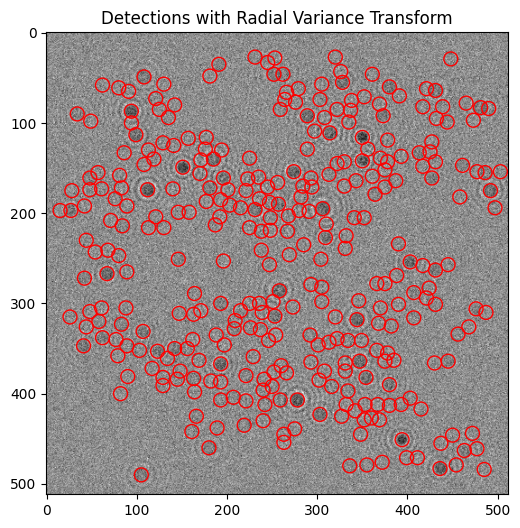

In [12]:
plt.figure(figsize=(6,6))
plt.imshow(data[...,1], cmap="gray")
plt.scatter(detections_rvt[:,1], detections_rvt[:,0], s = 100, facecolors='none', edgecolors='r')
plt.title("Detections with Radial Variance Transform") 

#### 2.1.3 - Optimizing the parameters for the RVT pipeline

xxx

In [13]:
radius = 6 # Radius of the particle in pixels
centroids = labels[:, :2] # We use the labels as the ground truth
mask = np.zeros_like(data[...,1])

In [14]:
def add_bin_circles(positions, radius, image):
    """Add circles to an image."""
    im = image.copy()
    
    if len(positions) == 0:
        return im
    
    for position in positions:
        rr, cc = skimage.draw.disk(position, radius)
        im[rr, cc] = 1
    return im

In [15]:
GT_particles = add_bin_circles(centroids, radius, mask)

Text(0.5, 1.0, 'Ground truth particles')

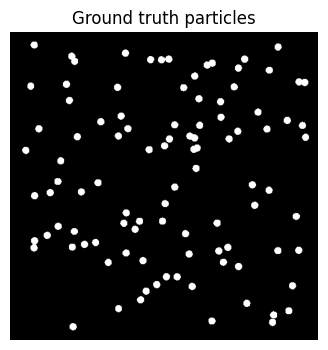

In [16]:
plt.figure(figsize=(4, 4))
plt.imshow(GT_particles, cmap="gray")
plt.axis("off")
plt.title("Ground truth particles")

In [17]:
from scipy.optimize import minimize

def get_F1_score(Pred_Particles, GT_particles):
    """Get the F1 score between the predicted particles and the ground truth."""
    # True positives - Overlap between the mask and the ground truth
    TP = np.sum(Pred_Particles * GT_particles)
    # False positives - Detections that are not in the ground truth
    FP = np.sum(Pred_Particles) - TP
    # False negatives - Ground truth particles that were not detected
    FN = np.sum(GT_particles) - TP

    # F1 score
    F1 = 2 * TP / (2 * TP + FP + FN)
    return F1

def objective(params):
    """Objective function for the optimization of the Radial Variance Transform pipeline."""

    rmin, rmax, th_scale, min_distance = params

    detections = rvt_pipeline(data, rmin = round(rmin), rmax = round(rmax), th_scale = th_scale, min_distance = round(min_distance))

    #Remove detections that are too close to the border with size radius
    if len(detections) > 0:
        detections = detections[(detections[:,0] > radius) & (detections[:,0] < data.shape[0] - radius) & 
                                (detections[:,1] > radius) & (detections[:,1] < data.shape[1] - radius)]

    # We create the mask with the detections
    mask_tmp = add_bin_circles(detections, radius, mask)

    # We calculate the F1 score
    F1 = get_F1_score(mask_tmp, GT_particles)

    return -F1


In [18]:
OPTIMIZE = True

# Initial guess for the parameters
initial_guess = [5, 50, 1, 7]

# Bounds for the parameters
bounds = [(1, 15), (15, 60), (0, 5), (3, 12)]

max_iter = 1000  # Maximum number of iterations

if OPTIMIZE:
    # Perform optimization
    result = minimize(objective, initial_guess, method='Nelder-Mead', bounds = bounds, tol=5e-1, options={'maxiter': max_iter})

    # Get the optimized parameters
    optimized_params = result.x
    print("Optimized parameters:", optimized_params)

    # Get the minimized value (objective function value at the optimal point)
    minimized_value = result.fun
    print("Minimized value:", minimized_value)

    # Get the optimized parameters
    rmin, rmax, th_scale, min_distance = optimized_params
    rmin, rmax, th_scale, min_distance = int(rmin), int(rmax), th_scale, int(min_distance)
    print("Optimized parameters:", rmin, rmax, th_scale, min_distance)


Optimized parameters: [ 1.50411678 35.53027906  1.79603039  8.69009987]
Minimized value: -0.6701173959445037
Optimized parameters: 1 35 1.7960303865493974 8


In [19]:
detections_rvt = rvt_pipeline(data, rmin = rmin, rmax = rmax, th_scale = th_scale, min_distance = min_distance)

Text(0.5, 1.0, 'Detections with RVT and optimized threshold')

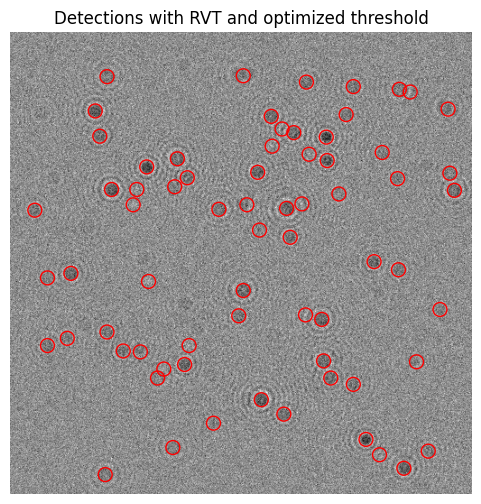

In [20]:
### For RVT
plt.figure(figsize=(6,6))
plt.imshow(data[...,1], cmap="gray")
plt.scatter(detections_rvt[:,1], detections_rvt[:,0], s = 100, facecolors='none', edgecolors='r')
plt.axis('off')
plt.title("Detections with RVT and optimized threshold")

In [21]:
F1_score_rvt = get_F1_score(add_bin_circles(detections_rvt, radius, mask), GT_particles)
print("F1 score for RVT:", F1_score_rvt)

F1 score for RVT: 0.568196371398079


### 2.2 Detecting particles using LodeSTAR model

xxx

#### 2.2.1  Prepare the Training Crop
We will use a single crop of a single particle to train the neural network.

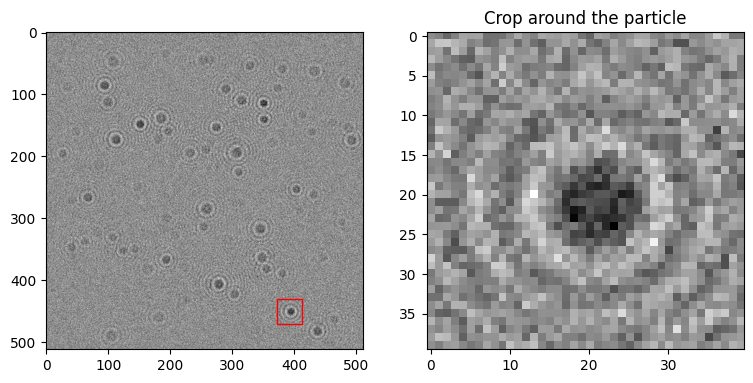

In [22]:
import matplotlib.patches as patches

crop_size = 40
labels_idx = 11

# We crop the image around the particle (based on the labels) - One could also use the detections or manually select a particle.
crop_x0 = int(labels[labels_idx, 0] - crop_size/2)
crop_y0 = int(labels[labels_idx, 1] - crop_size/2)

crop = data[crop_x0:crop_x0 + crop_size, crop_y0:crop_y0 + crop_size, :]

plt.figure(figsize=(9, 6))

plt.subplot(1, 2, 1)
plt.imshow(data[...,1], cmap="gray")
plt.gca().add_patch(patches.Rectangle((crop_y0, crop_x0), crop_size, crop_size,
                                      linewidth=1, edgecolor="r",
                                      facecolor="none"))

plt.subplot(1, 2, 2)
plt.title("Crop around the particle")
plt.imshow(crop[...,1], cmap="gray")

plt.show()

#### 2.2.2  Prepare pipeline and train model
We will create a pipeline for training the LodeSTAR model

In [23]:
x,y=np.meshgrid(
    np.arange(crop_size)-crop_size,
    np.arange(crop_size)-crop_size
    )

def grad(dx1,dx2,dy1,dy2):
    def inner(image):
        image[...,0]+=dx1*x+dy1*y
        image[...,1]+=dx2*x+dy2*y
        return image
    return inner

addgrad=dt.Lambda(
    grad,
    dx1=lambda: .02/40*np.random.randn(),
    dx2=lambda: .02/40*np.random.randn(),
    dy1=lambda: .02/40*np.random.randn(),
    dy2=lambda: .02/40*np.random.randn()
    )

In [24]:
IMAGE_SIZE = 40
PADDING = 64
WAVELENGTH = 633e-9
RESOLUTION = 1.14e-7


#For z-propagation
crop_propagation_forward = dt.get_propagation_matrix((IMAGE_SIZE + PADDING, ) * 2, 1e-7, RESOLUTION, WAVELENGTH)
crop_propagation_backward = dt.get_propagation_matrix((IMAGE_SIZE + PADDING, ) * 2, -1e-7, RESOLUTION, WAVELENGTH)


##################################
import numpy as np
import torch

training_pipeline = (
    dt.Value(crop)
    >> dt.FourierTransform() 
    >> dt.FourierTransformTransformation(crop_propagation_forward, crop_propagation_backward, lambda:np.random.randint(-10, 10)) 
    >> dt.InverseFourierTransform() 
    >> dt.Multiply(lambda: np.random.uniform(0.1, 3))
    >> dt.Add(lambda: np.random.uniform(-0.1, 0.1))
    >> addgrad
    >> dt.Gaussian(sigma=lambda: np.random.rand() * 1e-3)
    >> dt.MoveAxis(-1, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)

training_dataset = dt.pytorch.Dataset(training_pipeline, length=400, 
                                      replace=False)

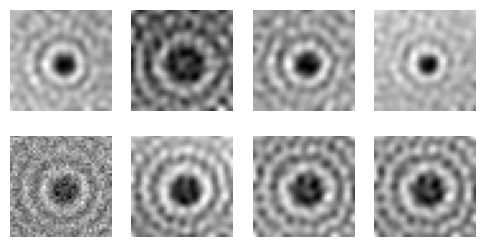

In [25]:
dataloader = dl.DataLoader(training_dataset, batch_size=8, shuffle=True)

batch = next(iter(dataloader))
#Visualize a batch
plt.figure(figsize=(6, 3))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(batch[0][i,1], cmap="gray")
    plt.axis("off")

In [26]:
lodestar = dl.LodeSTAR(n_transforms=4, optimizer=dl.Adam(lr=1e-4)).build()
trainer = dl.Trainer(max_epochs=100)
trainer.fit(lodestar, dataloader)

c:\Users\Fredrik\miniconda3\envs\dt\lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
c:\Users\Fredrik\miniconda3\envs\dt\lib\site-packages\lightning\pytorch\utilities\model_summary\model_summary.py:454: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
INFO: 
  | Name          | Type                       | Params
-------------------------------------------------------------
0 | model         | ConvolutionalNeuralNetwork | 251 K 
1 | between_loss  | L1Loss                     | 0     
2 | within_loss   | L1Loss                     | 0     
3 | train_metrics | MetricCollection           | 0     
4 | val_metrics   | MetricCollection           | 0     
5 | test_metrics  | MetricCollection           | 0     
6 | optimizer     | Adam                       | 0     
-------------------------------------------------------------

Epoch 15:  76%|███████▌  | 38/50 [00:02<00:00, 14.39it/s, v_num=37, train_between_image_disagreement_step=0.193, train_within_image_disagreement_step=0.144, train_between_image_disagreement_epoch=0.233, train_within_image_disagreement_epoch=0.162] 

c:\Users\Fredrik\miniconda3\envs\dt\lib\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


#### 2.2.3  Visualize result from trained LodeSTAR model

xxx

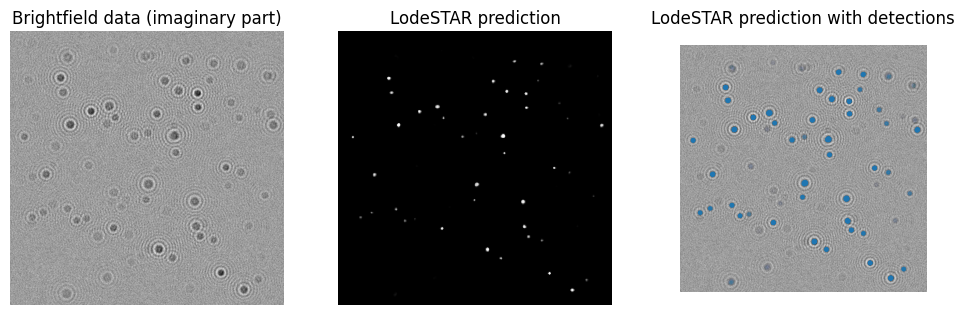

In [ ]:

torch_image = torch.from_numpy(data).permute(2, 0, 1).unsqueeze(0).float()
prediction = lodestar(torch_image)[0].detach().numpy()
x, y, rho = prediction[0], prediction[1], prediction[-1]

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Brightfield data (imaginary part)")
plt.imshow(data[...,1], cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("LodeSTAR prediction")
plt.imshow(rho, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("LodeSTAR prediction with detections")
plt.imshow(data[...,1], cmap="gray")
plt.scatter(y.flatten(), x.flatten(), alpha=rho.flatten() / rho.max(), s=5)
plt.axis("off")

plt.show()

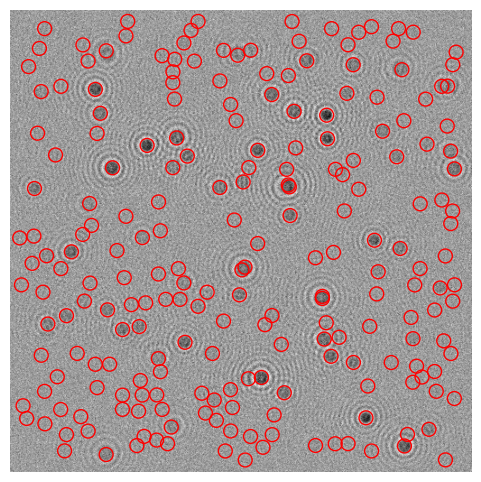

In [ ]:
alpha = 0.5
beta = 0.5
cutoff = 0.95
mode = "quantile"#"constant"

plt.figure(figsize=(6, 6))
torch_image = torch.from_numpy(data).permute(2, 0, 1).unsqueeze(0).float()
detections = lodestar.detect(torch_image, alpha=alpha, beta=beta, 
                                mode=mode, cutoff=cutoff)[0]

plt.imshow(data[...,1], cmap="gray")
plt.scatter(detections[:,1], detections[:,0], s = 100, facecolors='none', edgecolors='r')
plt.axis("off")

plt.show()

#### 2.2.4 Optimize the parameters for the LodeSTAR model

In [ ]:
def objective_l(params):
    """Objective function for the optimization of the LodeSTAR pipeline."""

    beta, cutoff = params

    torch_image = torch.from_numpy(data).permute(2, 0, 1).unsqueeze(0).float()
    detections = lodestar.detect(torch_image, alpha=1-beta, beta=beta, 
                                mode="quantile", cutoff=cutoff)[0]

    #Remove detections that are too close to the border with size radius
    if len(detections) > 0:
        detections = detections[(detections[:,0] > radius) & (detections[:,0] < data.shape[0] - radius) & 
                                (detections[:,1] > radius) & (detections[:,1] < data.shape[1] - radius)]

    # We create the mask with the detections
    mask_tmp = add_bin_circles(detections, radius, mask)

    # We calculate the F1 score
    F1 = get_F1_score(mask_tmp, GT_particles)
    return -F1

In [ ]:
OPTIMIZE = True

# Initial guess for the parameters
initial_guess = [0.5, 0.95]  # Example initial guess

# Bounds for the parameters
bounds = [(0, 1), (0.8, 1)]  # Example bounds

max_iter = 1000  # Maximum number of iterations

if OPTIMIZE:
    # Perform optimization
    result = minimize(objective_l, initial_guess, method='Nelder-Mead', bounds = bounds, options={'maxiter': max_iter})

    # Get the optimized parameters
    optimized_params = result.x
    print("Optimized parameters:", optimized_params)

    # Get the minimized value (objective function value at the optimal point)
    minimized_value = result.fun
    print("Minimized value:", minimized_value)

    # Get the optimized parameters
    beta, cutoff = optimized_params
    alpha = 1-beta
    print("Optimized parameters:", alpha, beta, cutoff)


Optimized parameters: [0.53046875 0.97671875]
Minimized value: -0.7005644073722591
Optimized parameters: 0.46953124999999996 0.53046875 0.9767187499999999


In [ ]:
detections_l = lodestar.detect(torch_image, alpha=alpha, beta=beta,
                                mode="quantile", cutoff=cutoff)[0]

Text(0.5, 1.0, 'Detections with LodeSTAR and optimized threshold')

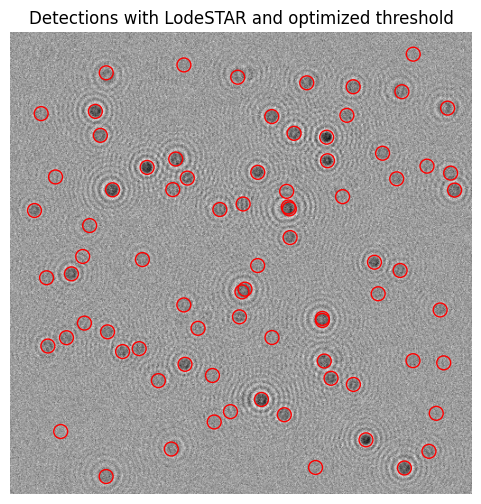

In [ ]:
### For RVT
plt.figure(figsize=(6,6))
plt.imshow(data[...,1], cmap="gray")
plt.scatter(detections_l[:,1], detections_l[:,0], s = 100, facecolors='none', edgecolors='r')
plt.axis('off')
plt.title("Detections with LodeSTAR and optimized threshold")

In [ ]:
# F1 score for LodeSTAR
F1_score_l = get_F1_score(add_bin_circles(detections_l, radius, mask), GT_particles)
print("F1 score for LodeSTAR:", F1_score_l)

F1 score for LodeSTAR: 0.7005644073722591


#### 2.3.1 Comparison between LodeSTAR and Radial Variance Transform - On individual ROIs

xxx


In [ ]:
padsize = 20 # Padding size, 20 pixels gives a total size of 40x40 pixels.

In [ ]:
def get_rois(data, positions, padsize):
    """Function for retrieving ROIs from data. Obs - rounded to integers"""

    rois = []
    for pos in positions:
        #Check if the roi is out of bounds
        if pos[1]-padsize < 0 or pos[1]+padsize >= data.shape[0] or pos[0]-padsize < 0 or pos[0]+padsize >= data.shape[1]:
            continue

        roi = data[int(pos[0]-padsize):int(pos[0]+padsize), int(pos[1]-padsize):int(pos[1]+padsize),:]
        
        rois.append(roi)
    return np.stack(rois)

In [ ]:
rois = get_rois(data, centroids, padsize)

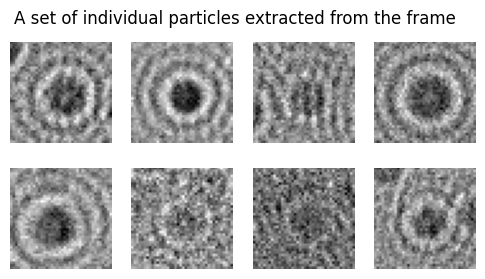

In [ ]:
plt.figure(figsize=(6, 3))
plt.suptitle("A set of individual particles extracted from the frame")
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(rois[i,...,1], cmap="gray")
    plt.axis("off")

In [ ]:
detections_rvt_rois = [rvt_pipeline(roi, rmin = rmin, rmax = rmax, th_scale = th_scale) for roi in rois]

#If more than 1 detection, take out the one closest to center
detections_rvt_rois_new = []
for detections in detections_rvt_rois:
    if len(detections) > 1:
        distances = np.linalg.norm(detections - padsize, axis=1)
        detections = detections[np.argmin(distances)]
    detections_rvt_rois_new.append(detections)


In [ ]:
detections_lodestar_rois = []

for roi in rois:
    torch_image = torch.from_numpy(roi).permute(2, 0, 1).unsqueeze(0).float()
    detections = lodestar.detect(torch_image, alpha=alpha, beta=beta, 
                                    mode=mode, cutoff=cutoff)[0].astype(int)
    detections_lodestar_rois.append(detections)

#If more than 1 detection, take out the one closest to center
detections_lodestar_rois_new = []
for detections in detections_lodestar_rois:
    if len(detections) > 1:
        distances = np.linalg.norm(detections - padsize, axis=1)
        detections = detections[np.argmin(distances)]
    detections_lodestar_rois_new.append(detections)

c:\Users\Fredrik\miniconda3\envs\dt\lib\site-packages\scipy\signal\_signaltools.py:278: RuntimeWarning: invalid value encountered in cast
  z = _sigtools._correlateND(in1zpadded, in2, out, val)


In [ ]:
#Range of pixels to check for the ground truth
th_pixels_range = np.linspace(1, padsize//2, 100)

In [ ]:
CR = []
CL = []

for th_pixels in th_pixels_range:
    #Count how many particles that are correctly identified
    correct_rvt = 0
    for detection_rvt in detections_rvt_rois_new:
        if np.linalg.norm(detection_rvt - padsize) < th_pixels:
            correct_rvt += 1

    correct_lodestar = 0
    for detection_lodestar in detections_lodestar_rois_new:
        if np.linalg.norm(detection_lodestar - padsize) < th_pixels:
            correct_lodestar += 1


    CR.append(np.round(correct_rvt/len(rois)*100, 1))
    CL.append(np.round(correct_lodestar/len(rois)*100, 1))

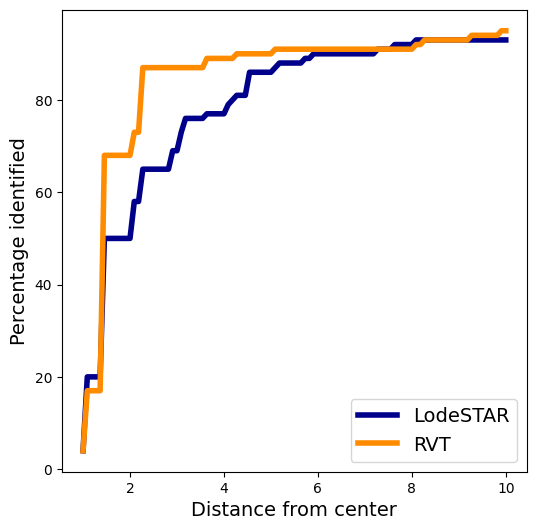

In [ ]:
#Visualize number of correct detections as a function of pixel range
plt.figure(figsize=(6, 6))
plt.plot(th_pixels_range, CL, label="LodeSTAR", linestyle="-", color = 'darkblue', linewidth=4)
plt.plot(th_pixels_range, CR, label="RVT", linestyle="-", color = 'darkorange', linewidth=4)
plt.legend(fontsize=14)
plt.xlabel("Distance from center", fontsize=14)
plt.ylabel("Percentage identified", fontsize=14)
plt.show()


In [ ]:
print(f"Correctly identified RVT: {correct_rvt}/{len(rois)} ({np.round(correct_rvt/len(rois)*100, 1)})%")
print(f"Correctly identified LodeSTAR: {correct_lodestar}/{len(rois)} ({np.round(correct_lodestar/len(rois)*100, 1)})%")

Correctly identified RVT: 95/100 (95.0)%
Correctly identified LodeSTAR: 93/100 (93.0)%


## 3 - Quantification of particle properties in Quantitiative field imaging

xxx

In [ ]:
def get_polarizability_rr(radius, refractive_index):
    """Calculate the polarizability of a particle."""
    return np.array(4/3 * np.pi * radius**3 * (refractive_index - 1.33))

In [ ]:
# Calculate the polarizabilities for all the particles
polarizabilities_rois = get_polarizability_rr(labels[:,3], labels[:,4])

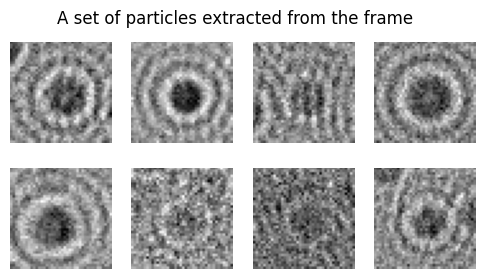

In [ ]:
plt.figure(figsize=(6, 3))
plt.suptitle("A set of particles extracted from the frame")
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(rois[i,...,1], cmap="gray")
    plt.axis("off")

### 3.1 Quantifying particle signal with a classical method

Radial Variance Transform and a gaussian fit followed by a weighted sum

In [ ]:
# Do a gaussian fit to the data and summarize the ROI
import numpy as np
import scipy

def gaussian_fit(input_data):
    """Fit a 2D Gaussian to the input data and return the Gaussian values."""
    # Get the dimensions of the image
    height, width = input_data.shape

    # Create meshgrid for the image coordinates
    x, y = np.meshgrid(np.arange(0, width)-width/2, np.arange(0, height)-height/2)

    # Stack the meshgrid coordinates
    data = np.column_stack((x.flatten(), y.flatten()))

    # Fit a 2D Gaussian distribution to the pixel intensity values
    fitf=lambda x,a,b,c,d,e: a*np.exp(-((x[:,0]-b)**2+(x[:,1]-c)**2)/(2*d**2))+e

    f=scipy.optimize.curve_fit(fitf,data,input_data.flatten()-np.mean(input_data.flatten()),p0=[1,0,0,1,0],bounds=((-1,-5,-5,.1,-1),((1,5,5,100,1))))

    #Define a gaussian mask by these parameters
    x, y = np.meshgrid(np.arange(0, width)-width/2, np.arange(0, height)-height/2)
    gaussian_values = f[0][0]*np.exp(-((x-f[0][1])**2+(y-f[0][2])**2)/(2*f[0][3]**2))+f[0][4]

    return gaussian_values

def radial_variance_gaussian(input_data, rmin = 4, rmax = 15, binary_gauss=False):
    """Creates a score map with Radial Variance Transform and fits a 2D Gaussian to the data. Returns the weighted sum of the pixel values."""

    # Apply the Radial Variance Transform to the input data
    input_data = rvt.rvt(input_data[...,1], rmin = rmin, rmax = rmax)

    # Fit a 2D Gaussian distribution to the pixel intensity values
    gaussian_values = gaussian_fit(input_data)

    if binary_gauss:
        gaussian_values = gaussian_values>np.mean(gaussian_values)*4

    # Sum the pixel values weighted by the Gaussian values
    weighted_sum = np.sum(input_data * gaussian_values)

    return weighted_sum

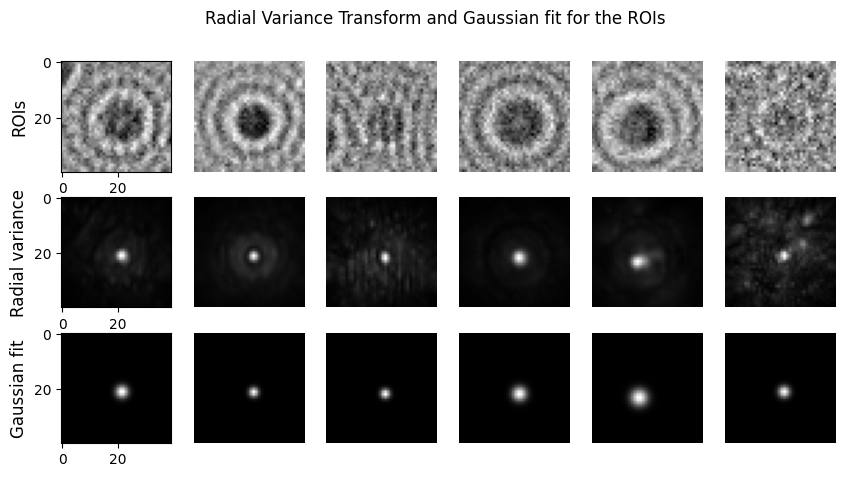

In [ ]:
det_map = np.array([rvt.rvt(roi[...,1], rmin = rmin, rmax = rmax) for roi in rois])
gaussian_map = np.array([gaussian_fit(det) for det in det_map])

plt.figure(figsize=(10, 5))
plt.suptitle("Radial Variance Transform and Gaussian fit for the ROIs")
for i in range(6):
    plt.subplot(3, 6, i+1)
    plt.imshow(rois[i][...,1], cmap="gray")
    if i == 0: plt.ylabel("ROIs", fontsize=12)
    else: plt.axis("off")
for i in range(6):
    plt.subplot(3, 6, i+7)
    plt.imshow(det_map[i], cmap="gray")
    if i == 0: plt.ylabel("Radial variance", fontsize=12)
    else: plt.axis("off")
for i in range(6):
    plt.subplot(3, 6, i+13)
    plt.imshow(gaussian_map[i], cmap="gray")
    if i == 0: plt.ylabel("Gaussian fit", fontsize=12)
    else: plt.axis("off")

In [ ]:
signal_sum_gauss = np.array([radial_variance_gaussian(roi, binary_gauss=True) for roi in rois])

Text(0.5, 1.0, 'Polarizability vs. Signal with RVT and gaussian fit on ROIs')

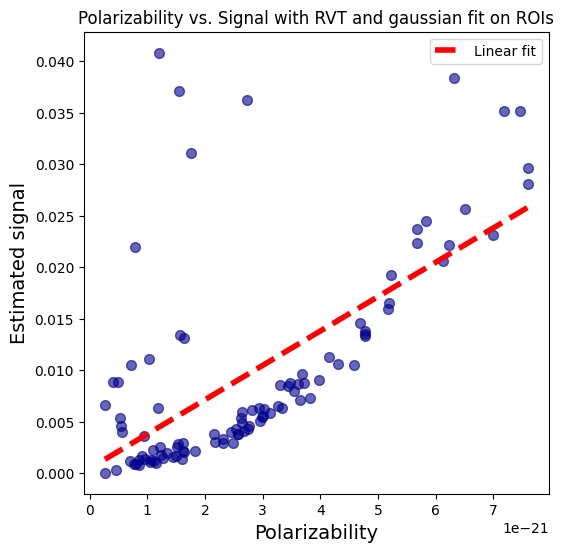

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(polarizabilities_rois, signal_sum_gauss, color="darkblue", alpha=0.6, s=50)
#line fit
coefficients = np.polyfit(polarizabilities_rois, np.abs(signal_sum_gauss), 1)
polynomial = np.poly1d(coefficients)
x_axis = np.linspace(polarizabilities_rois.min(), polarizabilities_rois.max(), 100)
y_axis = polynomial(x_axis)
plt.plot(x_axis, y_axis, color="red", linestyle="--", linewidth=4, label="Linear fit")
plt.xlabel("Polarizability", fontsize=14)
plt.ylabel("Estimated signal", fontsize=14)
plt.legend()
plt.title("Polarizability vs. Signal with RVT and gaussian fit on ROIs")

In [ ]:
#Find a fit that converts signal to polarizability
coefficients = np.polyfit(signal_sum_gauss, polarizabilities_rois, 4)
polynomial = np.poly1d(coefficients)

#Predict the polarizabilities
polarizabilities_pred = polynomial(signal_sum_gauss)

#Compute MSE, MAE
mse_g = np.mean((polarizabilities_rois - polarizabilities_pred)**2)
mae_g = np.mean(np.abs(polarizabilities_rois - polarizabilities_pred))

print(f"MSE: {mse_g}")
print(f"MAE: {mae_g}")


MSE: 1.4983372827465448e-42
MAE: 8.465638991547325e-22


### 3.2 Quantifying particle signal using a 2DCNN

#### 3.2.1 Defining the optical system

xxx

In [ ]:
IMAGE_SIZE = 40
NA = 1.3
MAGNIFICATION = 1
WAVELENGTH = 633e-9
RESOLUTION = 1.14e-7

In [ ]:
optics = dt.Brightfield(
    NA=NA,
    magnification=MAGNIFICATION,
    wavelength=WAVELENGTH,
    resolution=RESOLUTION,
    return_field=True, 
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
)

#### 3.2.2 Defining the particle(s)

In [ ]:
RADIUS_RANGE = (25e-9, 200e-9)
REFRACTIVE_INDEX_RANGE = (1.37, 1.6)

In [ ]:
particle = dt.MieSphere(
    position=lambda: (IMAGE_SIZE / 2, IMAGE_SIZE / 2) + np.random.rand(2) * 4 - 2,
    z=lambda: np.random.randn() * 5,
    radius=lambda:np.random.uniform(*RADIUS_RANGE),
    refractive_index=lambda: np.random.uniform(*REFRACTIVE_INDEX_RANGE),
    L=8,
    position_unit="pixel",
    
)

#### 3.2.3 Create dataset of particles

The noise is simulated as gaussian distributed noise, with independent real and imaginary parts. The amplitude of the noise is determined by the dummy property `level`, which is explicitly shared between the two features. Finally, the real and imaginary parts of the field are separated into two layers, and the plane wave is subtracted.

In [ ]:
noise = dt.Gaussian(
    mu=0, 
    sigma=lambda: 0.0025*np.random.rand() + 0.0025*np.random.rand(),
)

def func():
    def inner(image):
        image = image - 1
        output = np.zeros((*image.shape[:2], 2))
        output[..., 0:1] = np.real(image)
        output[..., 1:2] = np.imag(image)
        return output
    return inner


complex_to_float = dt.Lambda(func)

We now define how these objects combine. Note that the noise is added inside the optics. This means that it will have the same PSF as the sample, which is what is observed. 

In [ ]:
noisy_dataset = optics(particle >> noise) >> dt.Gaussian(sigma=0.002) >> dt.Gaussian(sigma=0.002j) >> complex_to_float
clean_dataset = optics(particle) >> complex_to_float

dataset = noisy_dataset & clean_dataset

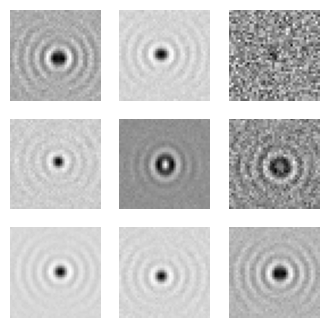

In [ ]:
#3x3 grid of augmented images
plt.figure(figsize=(4, 4))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = dataset.update().resolve()
    plt.imshow(img[0][...,1], cmap="gray")
    plt.axis('off')

#### 3.2.4 Defining the training label

We extract the parameters we want the network to learn. This is the integrated signal.

In [ ]:
def get_label():
    "Label function for the dataset. We sum the imaginary part of the image."
    def inner(image):
        return np.expand_dims(np.abs(np.array(np.sum(image[...,1]))), -1)
    return inner

In [ ]:
def get_polarizability(image):
    r = image[0].get_property("radius")
    n = image[0].get_property("refractive_index") - 1.33
    return np.array(4/3 * np.pi * r**3 * n)

#### 3.2.5 Defining quantification model (2DCNN)
xxx

In [ ]:
conv = dl.ConvolutionalNeuralNetwork(
    in_channels = 2, 
    hidden_channels=[16, 32], 
    out_channels = 64,
    pool = dl.torch.nn.MaxPool2d(kernel_size=2),
    out_activation=dl.torch.nn.ReLU
    )

mlp = dl.MultiLayerPerceptron(None, [32, 32], 1)

net = dl.Sequential(
    conv,
    mlp
)


In [ ]:
regressor = dl.Regressor(
    model=net,
    loss=dl.torch.nn.MSELoss(),
    optimizer=dl.Adam(),
)
cnn_regressor = regressor.create()

#### 3.2.6 Training of the model
xxx

In [ ]:
#Pipeline for generating images and labels.
image_and_signal_pipeline = noisy_dataset &  noisy_dataset >> dt.Lambda(get_label)

In [ ]:
training_dataset = dt.pytorch.Dataset(image_and_signal_pipeline, length=1000,replace=False)

dataloader = dl.DataLoader(training_dataset, batch_size=16, shuffle=True)

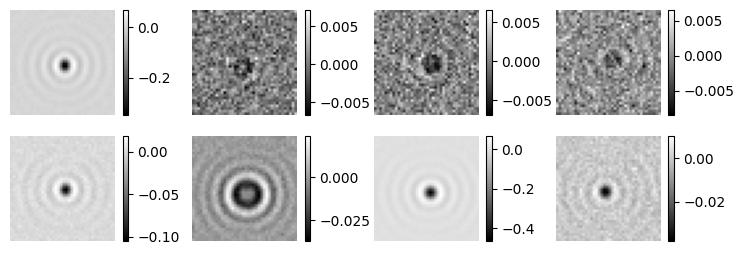

In [ ]:
batch = next(iter(dataloader))
#Visualize a batch
plt.figure(figsize=(9, 3))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(batch[0][i,1], cmap="gray")
    plt.colorbar()
    plt.axis("off")

In [ ]:
trainer = dl.Trainer(max_epochs=200)
trainer.fit(cnn_regressor, dataloader)

c:\Users\Fredrik\miniconda3\envs\dt\lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | Sequential       | 24.5 K
5 | optimizer     | Adam             | 0     
---------------------------------------------------
24.5 K    Trainable params
0         Non-trainable params
24.5 K    Total params
0.098     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val

Epoch 199: 100%|██████████| 63/63 [00:00<00:00, 95.71it/s, v_num=36, train_loss_step=0.00474, train_loss_epoch=0.00533]  


#### 3.2.7 Validating the model on simulated data and ROIs from frame.
xxx


In [ ]:
#Generate new data.
val_dataset = dt.pytorch.Dataset(image_and_signal_pipeline, length=200)
val_dataloader = dl.DataLoader(val_dataset, batch_size=16, shuffle=True)

#Predict the signal
predictions = []
labels_ = []
for batch in val_dataloader:
    predictions.append(cnn_regressor(batch[0]).detach().numpy())
    labels_.append(batch[1].detach().numpy())

#Concatenate the predictions and labels
predictions = np.concatenate(predictions)[:, 0]
labels_ = np.concatenate(labels_)[:, 0]


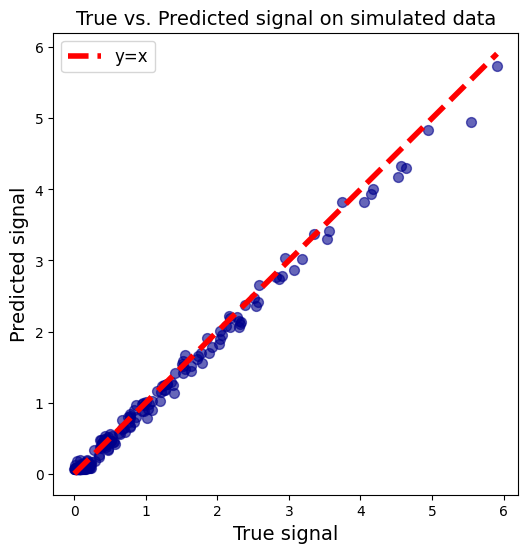

In [ ]:
#Scatterplot of the predicted signal vs the true signal
plt.figure(figsize=(6, 6))
plt.scatter(labels_, predictions, color="darkblue", alpha=0.6, s=50)
#y=x line
plt.plot([np.min(labels_), np.max(labels_)], [np.min(labels_), np.max(labels_)], color="red", linestyle="--", linewidth=4, label="y=x")
plt.xlabel("True signal", fontsize=14)
plt.ylabel("Predicted signal", fontsize=14)
plt.legend(fontsize=12)
plt.title("True vs. Predicted signal on simulated data", fontsize=14)
plt.show()


In [ ]:
#Predict on the rois
predictions_rois = [cnn_regressor(torch.from_numpy(roi).permute(2, 0, 1).unsqueeze(0).float()) for roi in rois]
predictions_rois = np.array([pred.detach().numpy()[0, 0] for pred in predictions_rois])

Text(0.5, 1.0, 'Polarizability vs. Signal predicted with CNN on ROIs')

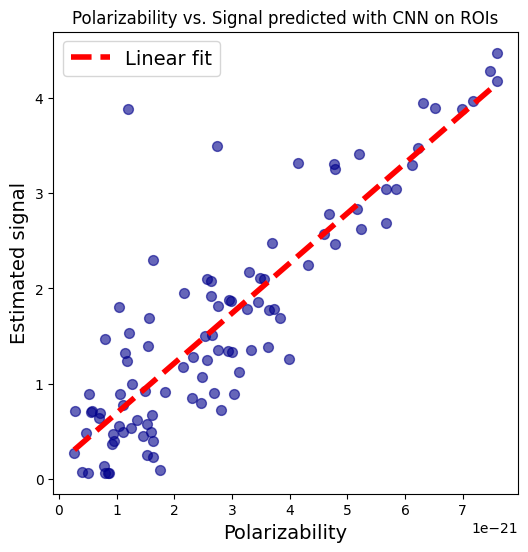

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(polarizabilities_rois, predictions_rois, color="darkblue", alpha=0.6, s=50)
#line fit
coefficients = np.polyfit(polarizabilities_rois, predictions_rois, 1)
polynomial = np.poly1d(coefficients)
x_axis = np.linspace(polarizabilities_rois.min(), polarizabilities_rois.max(), 100)
y_axis = polynomial(x_axis)
plt.plot(x_axis, y_axis, color="red", linestyle="--", linewidth=4, label="Linear fit")
plt.xlabel("Polarizability", fontsize=14)
plt.ylabel("Estimated signal", fontsize=14)
plt.legend(fontsize=12)
plt.title("Polarizability vs. Signal predicted with CNN on ROIs")

In [ ]:
# Find linear fit that converts signal to polarizability
coefficients = np.polyfit(predictions_rois, polarizabilities_rois, 3)
polynomial = np.poly1d(coefficients)

# Predict the polarizabilities
polarizabilities_pred = polynomial(predictions_rois)

# Compute MSE, MAE
mse_cnn = np.mean((polarizabilities_rois - polarizabilities_pred)**2)
mae_cnn = np.mean(np.abs(polarizabilities_rois - polarizabilities_pred))

print(f"MSE: {mse_cnn}")
print(f"MAE: {mae_cnn}")

MSE: 9.1925179259708e-43
MAE: 7.005485201049203e-22


### 3.4 Investigating the signal as dependence while keeping either refractive index or radius fixed.

#### 3.4.1 Fix refractive index 

In [ ]:
FIX_RI = 1.4
RADIUS_RANGE = np.linspace(25e-9, 200e-9, 100)
samples_per_case = 10
data_case = 'clean'
radiuses = np.concatenate([np.repeat(x, samples_per_case) for x in RADIUS_RANGE])

In [ ]:
DATA = []

for i, rad in enumerate(RADIUS_RANGE):
    if i % 10 == 0:
        print(f"Currently at {i}/100")

    particle = dt.MieSphere(
        position=lambda: (IMAGE_SIZE / 2, IMAGE_SIZE / 2) + np.random.rand(2) * 4 - 2,
        z=lambda: np.random.randn() * 5,
        radius=lambda: rad,
        refractive_index=lambda: FIX_RI,
        L=8,
        position_unit="pixel",
    )

    #Define the noise and optical system
    if data_case == 'noisy':
       dataset = optics(particle >> noise) >> dt.Gaussian(sigma=0.002) >> dt.Gaussian(sigma=0.002j) >> complex_to_float
    else:
        dataset = optics(particle) >> complex_to_float

    #Get the particles
    for _ in range(samples_per_case):
        DATA.append(
            dataset.update().resolve()
        )
        
DATA = np.array(DATA)

Currently at 0/100
Currently at 10/100
Currently at 20/100
Currently at 30/100
Currently at 40/100
Currently at 50/100
Currently at 60/100
Currently at 70/100
Currently at 80/100
Currently at 90/100


In [ ]:
# Get the theoretical polarizabilities
theoretical_pol = get_polarizability_rr(radiuses, FIX_RI)

In [ ]:
signal_sum_gauss_fix_ri = np.array([radial_variance_gaussian(roi,binary_gauss=True) for roi in DATA])

In [ ]:
signal_sum_cnn_fix_ri = cnn_regressor(torch.from_numpy(DATA).permute(0, 3, 1, 2).float()).detach().numpy()[:, 0]

In [ ]:
#Normalize the signals
signal_sum_gauss_fix_ri = (signal_sum_gauss_fix_ri - signal_sum_gauss_fix_ri.min()) / (signal_sum_gauss_fix_ri.max() - signal_sum_gauss_fix_ri.min())
signal_sum_cnn_fix_ri = (signal_sum_cnn_fix_ri - signal_sum_cnn_fix_ri.min()) / (signal_sum_cnn_fix_ri.max() - signal_sum_cnn_fix_ri.min())
theoretical_pol = (theoretical_pol - theoretical_pol.min()) / (theoretical_pol.max() - theoretical_pol.min())

Text(0.5, 1.0, 'Polarizability vs. Signal with RVT and gaussian fit on ROIs')

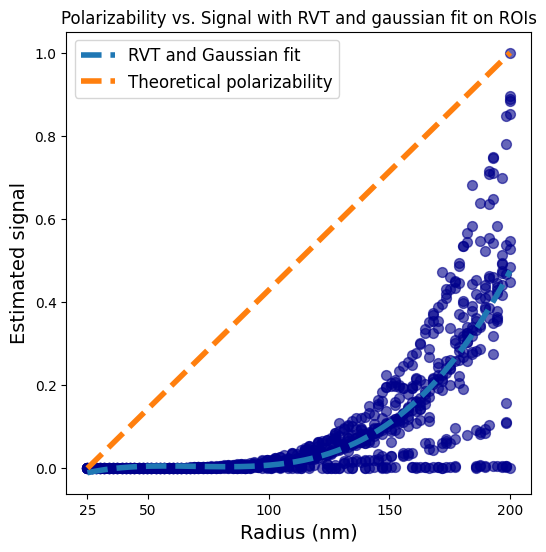

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(radiuses, signal_sum_gauss_fix_ri, color="darkblue", alpha=0.6, s=50)

x_axis = np.linspace(radiuses.min(), radiuses.max(), 200)

#Polynomial line for gaussian and RVT fit
coefficients = np.polyfit(radiuses, signal_sum_gauss_fix_ri, 3)
polynomial = np.poly1d(coefficients)
y_axis = polynomial(x_axis)
plt.plot(x_axis, y_axis, linestyle="--", linewidth=4, label="RVT and Gaussian fit")

#Polynomial line for theoretical
coefficients = np.polyfit(radiuses, theoretical_pol, 3)
polynomial = np.poly1d(coefficients)
y_axis = polynomial(x_axis)
plt.plot(x_axis, y_axis, linestyle="--", linewidth=4, label="Theoretical polarizability")

plt.xticks([25e-9, 50e-9, 100e-9, 150e-9, 200e-9], ["25", "50", "100", "150", "200"])

plt.xlabel("Radius (nm)", fontsize=14)
plt.ylabel("Estimated signal", fontsize=14)
plt.legend(fontsize=12)
plt.title("Polarizability vs. Signal with RVT and gaussian fit on ROIs")

Text(0.5, 1.0, 'Polarizability vs. Signal with RVT and gaussian fit on ROIs')

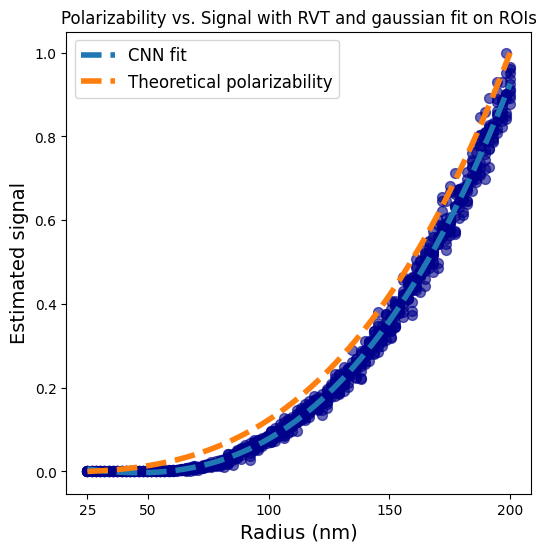

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(radiuses, signal_sum_cnn_fix_ri, color="darkblue", alpha=0.6, s=50)

x_axis = np.linspace(radiuses.min(), radiuses.max(), 200)

#Polynomial line for gaussian and RVT fit
coefficients = np.polyfit(radiuses, signal_sum_cnn_fix_ri, 3)
polynomial = np.poly1d(coefficients)
y_axis = polynomial(x_axis)
plt.plot(x_axis, y_axis, linestyle="--", linewidth=4, label="CNN fit")

#Polynomial line for theoretical
coefficients = np.polyfit(radiuses, theoretical_pol, 3)
polynomial = np.poly1d(coefficients)
y_axis = polynomial(x_axis)
plt.plot(x_axis, y_axis, linestyle="--", linewidth=4, label="Theoretical polarizability")

plt.xticks([25e-9, 50e-9, 100e-9, 150e-9, 200e-9], ["25", "50", "100", "150", "200"])

plt.xlabel("Radius (nm)", fontsize=14)
plt.ylabel("Estimated signal", fontsize=14)
plt.legend(fontsize=12)
plt.title("Polarizability vs. Signal with RVT and gaussian fit on ROIs")

#### 3.4.1 Fix radius 

In [ ]:
FIX_RADIUS = 150e-9
RI_RANGE = np.linspace(1.37, 1.6, 100)
samples_per_case = 10
data_case = 'clean'
riis = np.concatenate([np.repeat(x, samples_per_case) for x in RI_RANGE])

In [ ]:
DATA = []

for i, ri in enumerate(RI_RANGE):
    if i % 10 == 0:
        print(f"Currently at {i}/100")

    particle = dt.MieSphere(
        position=lambda: (IMAGE_SIZE / 2, IMAGE_SIZE / 2) + np.random.rand(2) * 4 - 2,
        z=lambda: np.random.randn() * 5,
        radius=lambda: FIX_RADIUS,
        refractive_index=lambda: ri,
        L=8,
        position_unit="pixel",
    )

    #Define the noise and optical system
    if data_case == 'noisy':
       dataset = optics(particle >> noise) >> dt.Gaussian(sigma=0.002) >> dt.Gaussian(sigma=0.002j) >> complex_to_float
    else:
        dataset = optics(particle) >> complex_to_float

    #Get the particles
    for _ in range(samples_per_case):
        DATA.append(
            dataset.update().resolve()
        )

DATA = np.array(DATA)


Currently at 0/100
Currently at 10/100
Currently at 20/100
Currently at 30/100
Currently at 40/100
Currently at 50/100
Currently at 60/100
Currently at 70/100
Currently at 80/100
Currently at 90/100


In [ ]:
# Get the theoretical polarizabilities
theoretical_pol = get_polarizability_rr(FIX_RADIUS, riis)

In [ ]:
signal_sum_gauss_fix_radius = np.array([radial_variance_gaussian(roi, binary_gauss=True) for roi in DATA])

In [ ]:
signal_sum_cnn_fix_radius = cnn_regressor(torch.from_numpy(DATA).permute(0, 3, 1, 2).float()).detach().numpy()[:, 0]

In [ ]:
#Normalize the signals
signal_sum_gauss_fix_radius = (signal_sum_gauss_fix_radius - signal_sum_gauss_fix_radius.min()) / (signal_sum_gauss_fix_radius.max() - signal_sum_gauss_fix_radius.min())
signal_sum_cnn_fix_radius = (signal_sum_cnn_fix_radius - signal_sum_cnn_fix_radius.min()) / (signal_sum_cnn_fix_radius.max() - signal_sum_cnn_fix_radius.min())
theoretical_pol = (theoretical_pol - theoretical_pol.min()) / (theoretical_pol.max() - theoretical_pol.min())

Text(0.5, 1.0, 'Polarizability vs. Signal with RVT and gaussian fit')

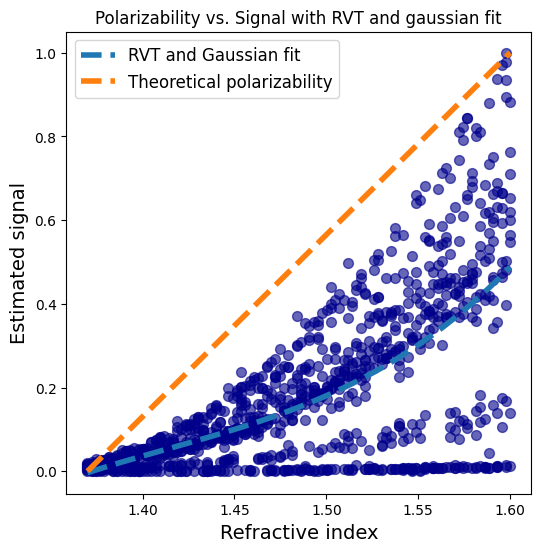

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(riis, signal_sum_gauss_fix_radius, color="darkblue", alpha=0.6, s=50)

x_axis = np.linspace(riis.min(), riis.max(), 200)

#Polynomial line for gaussian and RVT fit
coefficients = np.polyfit(riis, signal_sum_gauss_fix_radius, 3)
polynomial = np.poly1d(coefficients)
y_axis = polynomial(x_axis)
plt.plot(x_axis, y_axis, linestyle="--", linewidth=4, label="RVT and Gaussian fit")

#Polynomial line for theoretical
coefficients = np.polyfit(riis, theoretical_pol, 3)
polynomial = np.poly1d(coefficients)
y_axis = polynomial(x_axis)
plt.plot(x_axis, y_axis, linestyle="--", linewidth=4, label="Theoretical polarizability")


plt.xlabel("Refractive index", fontsize=14)
plt.ylabel("Estimated signal", fontsize=14)
plt.legend(fontsize=12)
plt.title("Polarizability vs. Signal with RVT and gaussian fit")

Text(0.5, 1.0, 'Polarizability vs. Signal with CNN fit')

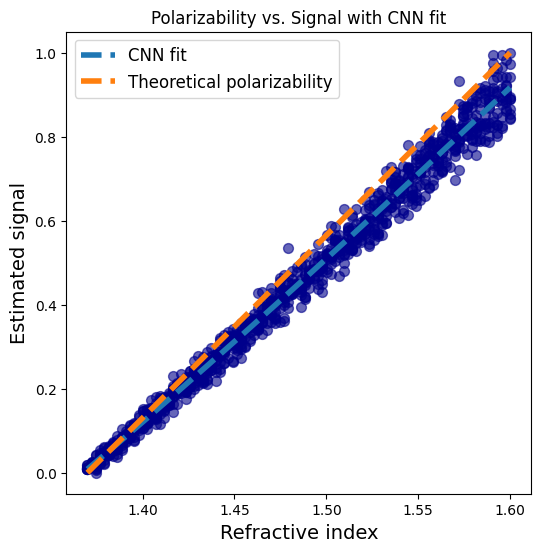

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(riis, signal_sum_cnn_fix_radius, color="darkblue", alpha=0.6, s=50)

x_axis = np.linspace(riis.min(), riis.max(), 200)

#Polynomial line for CNN fit
coefficients = np.polyfit(riis, signal_sum_cnn_fix_radius, 3)
polynomial = np.poly1d(coefficients)
y_axis = polynomial(x_axis)
plt.plot(x_axis, y_axis, linestyle="--", linewidth=4, label="CNN fit")

#Polynomial line for theoretical
coefficients = np.polyfit(riis, theoretical_pol, 3)
polynomial = np.poly1d(coefficients)
y_axis = polynomial(x_axis)
plt.plot(x_axis, y_axis, linestyle="--", linewidth=4, label="Theoretical polarizability")

plt.xlabel("Refractive index", fontsize=14)
plt.ylabel("Estimated signal", fontsize=14)
plt.legend(fontsize=12)
plt.title("Polarizability vs. Signal with CNN fit")

## 4. Combining detection and quantification in Quantitative field imaging
xxx

Text(0.5, 1.0, 'Ground truth detections and Polarizability')

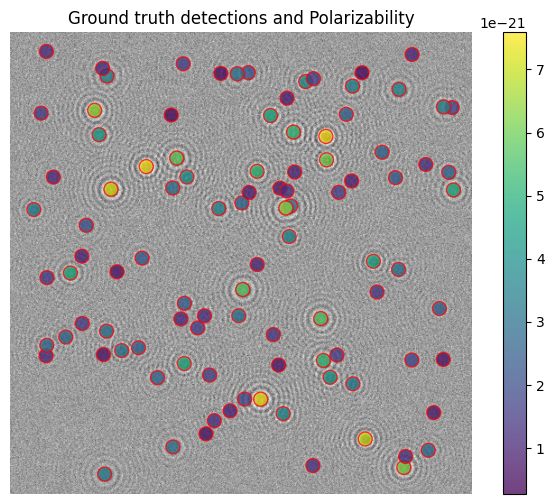

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(data[...,1], cmap="gray")
plt.scatter(labels[:,1], labels[:,0], s = 100, c = polarizabilities_rois, cmap = "viridis", edgecolors='r', alpha = 0.75)
plt.colorbar()
plt.axis("off")
plt.title("Ground truth detections and Polarizability")

### 4.1 RVT and Gaussian fit for particle detection and quantification

In [ ]:
def rvt_gauss_full_frame_pipeline(data, rmin = 4, rmax = 25, th_scale = 0.3, min_distance = 7, padsize = 20):

    #Detect particles with RVT
    detections = rvt_pipeline(
        data, rmin = rmin, rmax = rmax, th_scale = th_scale, min_distance = min_distance
        )
    
    #If no detections, throw error.
    if len(detections) > 0:
        
        #Check so detections is not out of bounds
        detections = detections[(detections[:,0] > padsize) & (detections[:,0] < data.shape[0] - padsize) & 
                                (detections[:,1] > padsize) & (detections[:,1] < data.shape[1] - padsize)]

        #Get the signals
        signals = np.array([radial_variance_gaussian(roi, rmin = 3, rmax = 15, binary_gauss=True) for roi in get_rois(data, detections, padsize)])

        return detections, signals
    else:
        print("No detections")

In [ ]:
detections, signals = rvt_gauss_full_frame_pipeline(data, rmin = rmin, rmax = rmax, th_scale = th_scale, min_distance = min_distance, padsize = 20)

Text(0.5, 1.0, 'Detections with RVT and Gaussian fit on full frame')

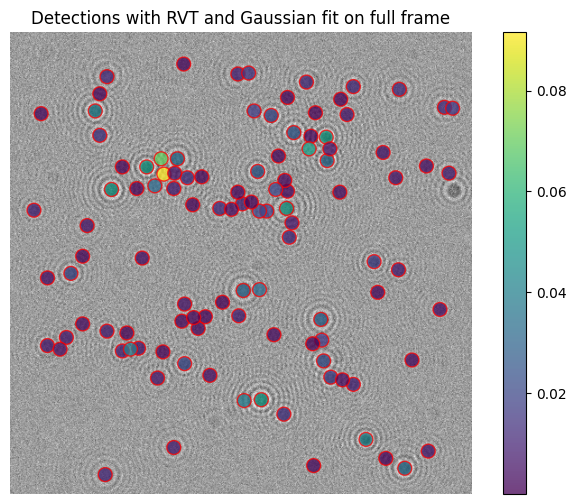

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(data[...,1], cmap="gray")
plt.scatter(detections[:,1], detections[:,0], s = 100, c = signals, cmap = "viridis", edgecolors='r', alpha = 0.75)
plt.colorbar()
plt.axis("off")
plt.title("Detections with RVT and Gaussian fit on full frame")


### 4.2 LodeSTAR and 2DCNN for particle detection and quantification
xxx

In [ ]:
def LodeSTAR_2dcnn_full_frame_pipeline(data, lodestar, cnn_regressor, alpha = 0.5, beta = 0.5, cutoff = 0.95, padsize = 20):

    #Transform data to a Tensor
    torch_image = torch.from_numpy(data).permute(2, 0, 1).unsqueeze(0).float()

    #Detect particles with LodeSTAR
    detections = lodestar.detect(torch_image, alpha=alpha, beta=beta, 
                                    mode="quantile", cutoff=cutoff)[0]
    
    #If no detections, throw error.
    if len(detections) > 0:
        
        #Check so detections is not out of bounds
        detections = detections[(detections[:,0] > padsize) & (detections[:,0] < data.shape[0] - padsize) & 
                                (detections[:,1] > padsize) & (detections[:,1] < data.shape[1] - padsize)]

        #Get the signals
        signals = np.array([cnn_regressor(torch.from_numpy(roi).permute(2, 0, 1).unsqueeze(0).float()).detach().numpy()[0, 0] for roi in get_rois(data, detections, padsize)])

        return detections, signals

    else:
        print("No detections")

In [ ]:
detections, signals = LodeSTAR_2dcnn_full_frame_pipeline(data, lodestar, cnn_regressor, alpha = alpha, beta = beta, cutoff = cutoff, padsize = 20)

Text(0.5, 1.0, 'Detections with LodeSTAR and 2DCNN on full frame')

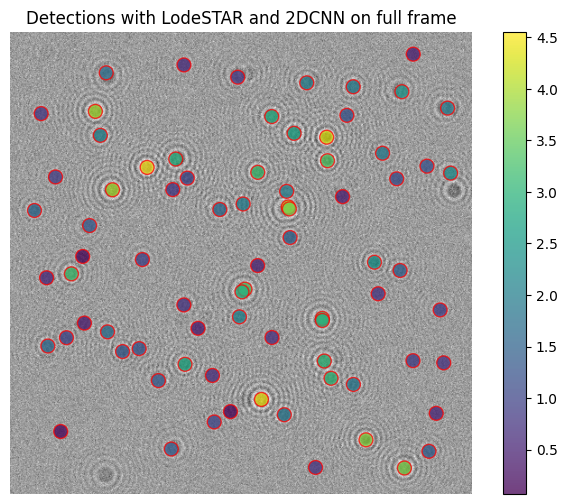

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(data[...,1], cmap="gray")
plt.scatter(detections[:,1], detections[:,0], s = 100, c = signals, cmap = "viridis", edgecolors='r', alpha = 0.75)
plt.colorbar()
plt.axis("off")
plt.title("Detections with LodeSTAR and 2DCNN on full frame")